In [2]:
!pip install mujoco
!pip install mujoco_mjx
!pip install brax

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.8/211.8 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 694.7/694.7 kB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 998.9/998.9 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 18.0 MB/s eta 0:00:00
  Created wheel for ml-collections: filename=ml_collections-0.1.1-py3-none-any.whl size=94506 sha256=79062698a9b9b5ce8f645689436a7bf544b84d995e68d47a17d2b72143ba14a1
  Stored in directory: /root/.cache/pip/wheels/7b/89/c9/a9b8

In [3]:
#@title Check if MuJoCo installation was successful

from google.colab import files

import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Tell XLA to use Triton GEMM, this improves steps/sec by ~30% on some GPUs
xla_flags = os.environ.get('XLA_FLAGS', '')
xla_flags += ' --xla_gpu_triton_gemm_any=True'
os.environ['XLA_FLAGS'] = xla_flags


Setting environment variable to use GPU rendering:
env: MUJOCO_GL=egl
Checking that the installation succeeded:
Installation successful.


In [4]:
!pip install patool
import patoolib
patoolib.extract_archive("/content/drive/MyDrive/Spider.rar", outdir="/content/")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.0/96.0 kB 3.3 MB/s eta 0:00:00


INFO patool: Extracting /content/drive/MyDrive/Spider.rar ...
INFO:patool:Extracting /content/drive/MyDrive/Spider.rar ...
INFO patool: running /usr/bin/unrar x -- /content/drive/MyDrive/Spider.rar
INFO:patool:running /usr/bin/unrar x -- /content/drive/MyDrive/Spider.rar
INFO patool:     with cwd='/content/', input=''
INFO:patool:    with cwd='/content/', input=''
INFO patool: ... /content/drive/MyDrive/Spider.rar extracted to `/content/'.
INFO:patool:... /content/drive/MyDrive/Spider.rar extracted to `/content/'.


'/content/'

In [5]:
#@title Import packages for plotting and creating graphics
import time
import itertools
import numpy as np
from typing import Callable, NamedTuple, Optional, Union, List

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

Installing mediapy:
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.7 MB/s eta 0:00:00


In [6]:
#@title Import MuJoCo, MJX, and Brax
from datetime import datetime
from etils import epath
import functools
from IPython.display import HTML
from typing import Any, Dict, Sequence, Tuple, Union
import os
from ml_collections import config_dict
import math


import jax
from jax import numpy as jp
import numpy as np
from flax.training import orbax_utils
from flax import struct
from matplotlib import pyplot as plt
import mediapy as media
from orbax import checkpoint as ocp

import mujoco
from mujoco import mjx

from brax import base
from brax import envs
# from brax import math
from brax.base import Base, Motion, Transform
from brax.envs.base import Env, PipelineEnv, State
from brax.mjx.base import State as MjxState
from brax.training.agents.ppo import train as ppo
from brax.training.agents.ppo import networks as ppo_networks
from brax.io import html, mjcf, model


In [ ]:
with open('/content/Spider_Assembly_fineMesh_frictionDamp/urdf/final_noFrictionLoss_noCoxaCon_explicitConPair_colab.xml', 'r') as f:
  xml = f.read()

mj_model = mujoco.MjModel.from_xml_string(xml)
mj_data = mujoco.MjData(mj_model)
renderer = mujoco.Renderer(mj_model, height=480, width=640)

In [ ]:
mjx_model = mjx.put_model(mj_model)
mjx_data = mjx.put_data(mj_model, mj_data)

/usr/local/lib/python3.10/dist-packages/jax/_src/interpreters/xla.py:155: RuntimeWarning: overflow encountered in cast
  return np.asarray(x, dtypes.canonicalize_dtype(x.dtype))


In [ ]:
print(mj_data.qpos, type(mj_data.qpos))
print(mjx_data.qpos, type(mjx_data.qpos), mjx_data.qpos.devices())

[0.   0.   0.23 1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.  ] <class 'numpy.ndarray'>
[0.   0.   0.23 1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.  ] <class 'jaxlib.xla_extension.ArrayImpl'> {cuda(id=0)}


In [ ]:
# enable joint visualization option:
scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = True

duration = 4  # (seconds)
framerate = 60  # (Hz)

frames = []
mujoco.mj_resetData(mj_model, mj_data)
while mj_data.time < duration:
  mujoco.mj_step(mj_model, mj_data)
  if len(frames) < mj_data.time * framerate:
    renderer.update_scene(mj_data, scene_option=scene_option)
    pixels = renderer.render()
    frames.append(pixels)

# Simulate and display video.
media.show_video(frames, fps=framerate)

In [ ]:

jit_step = jax.jit(mjx.step)

frames = []
mujoco.mj_resetData(mj_model, mj_data)
mjx_data = mjx.put_data(mj_model, mj_data)
while mjx_data.time < duration:
  mjx_data = jit_step(mjx_model, mjx_data)
  if len(frames) < mjx_data.time * framerate:
    mj_data = mjx.get_data(mj_model, mjx_data)
    renderer.update_scene(mj_data, scene_option=scene_option)
    pixels = renderer.render()
    frames.append(pixels)

media.show_video(frames, fps=framerate)

In [ ]:
rng = jax.random.PRNGKey(0)
rng = jax.random.split(rng, 4096)
batch = jax.vmap(lambda rng: mjx_data.replace(qpos=jax.random.uniform(rng, (25,))))(rng)

jit_step = jax.jit(jax.vmap(mjx.step, in_axes=(None, 0)))
batch = jit_step(mjx_model, batch)

print(batch.qpos)

In [ ]:
batched_mj_data = mjx.get_data(mj_model, batch)
print([d.qpos for d in batched_mj_data])

In [23]:
xml_path = r'/content/Spider_Assembly_fineMesh_frictionDamp/urdf/final_noFrictionLoss_noCoxaCon_explicitConPair_colab.xml'

class HexapodV0_3(PipelineEnv):
    def __init__(self,
                 xml_path,
                 terminateWhenTilt=True,
                 terminateWhenTiltGreaterThan=40 * math.pi / 180,
                 baseTiltSigma=0.3,
                 baseTiltCoef=1,

                 terminateWhenFumersColide=False,
                 femurCollisionSigma=0.5,
                 femurCollisionCoef=0.1,

                 correctDirectionSigma=0.3,
                 correctDirectionWeight=1,
                 deviationAngleSigma=0.3,
                 deviationAngleWeight=2,

                 baseHeightSigma=0.3,
                 baseHeightCoef=1,
                 terminateWhenLow=True,
                 baseHeightLowerLimit=0.15,
                 baseOscillationSigma=0.3,
                 baseOscillationCoef=1,

                 rewardForTibiaTip=False,
                 tibiaRewardCoef=1,

                 powerCoef=0.001,
                 continuityCoef=0.01,

                 includeBaseAngularVels=True,
                 includeTibiaTipSensors=False,
                 nStacks=3,
                 physics_steps_per_control_step=10,

                 resetPosLowHigh=[jp.array([-0.2, -0.2, 0.23]), jp.array([0.2, 0.2, 0.4])],
                 resetOriLowHigh=[jp.array([-math.pi/12, -math.pi/12, -math.pi]), jp.array([math.pi/12, math.pi/12, -math.pi])],
                 resetJointsPosLowHigh = [jp.array([-math.pi/12]*18), jp.array([math.pi/12]*18)],
                 resetJointsVelsLowHigh=[jp.array([-0.3]*24), jp.array([-0.3]*24)],
                 **kwargs
                 ):

        self.mj_model = mujoco.MjModel.from_xml_path(xml_path)
        self.mj_model.opt.solver = mujoco.mjtSolver.mjSOL_NEWTON
        self.mj_model.opt.iterations = 6
        self.mj_model.opt.ls_iterations = 6

        sys = mjcf.load_model(self.mj_model)

        kwargs['n_frames'] = kwargs.get(
            'n_frames', physics_steps_per_control_step)
        kwargs['backend'] = 'mjx'
        super().__init__(sys, **kwargs)

        self._terminateWhenTilt = terminateWhenTilt
        self._terminateWhenTiltGreaterThan = terminateWhenTiltGreaterThan
        self._baseTiltSigma= baseTiltSigma
        self._baseTiltCoef= baseTiltCoef
        self._terminateWhenFumersColide = terminateWhenFumersColide
        self._femurCollisionSigma = femurCollisionSigma
        self._femurCollisionCoef = femurCollisionCoef
        self._correctDirectionSigma = correctDirectionSigma
        self._correctDirectionWeight = correctDirectionWeight
        self._deviationAngleSigma = deviationAngleSigma
        self._deviationAngleWeight = deviationAngleWeight
        self._baseHeightSigma = baseHeightSigma
        self._baseHeightCoef = baseHeightCoef
        self._terminateWhenLow = terminateWhenLow
        self._baseHeightLowerLimit = baseHeightLowerLimit
        self._baseOscillationSigma = baseOscillationSigma
        self._baseOscillationCoef = baseOscillationCoef
        self._rewardForTibiaTip = rewardForTibiaTip
        self._tibiaRewardCoef = tibiaRewardCoef
        self._powerCoef = powerCoef
        self._continuityCoef = continuityCoef
        self._includeBaseAngularVels = includeBaseAngularVels
        self._includeTibiaTipSensors = includeTibiaTipSensors
        self._resetPosLowHigh = resetPosLowHigh
        self._resetOriLowHigh = resetOriLowHigh
        self._resetJointsPosLowHigh = resetJointsPosLowHigh
        self._resetJointsVelsLowHigh = resetJointsVelsLowHigh
        self._includeBaseAngularVels = includeBaseAngularVels
        self._includeTibiaTipSensors = includeTibiaTipSensors
        self._nStacks = nStacks
        self._physics_steps_per_control_step = physics_steps_per_control_step

    def reset(self, rng: jp.ndarray) -> State:
        """Resets the environment to an initial state."""
        rng, rng1, rng2, rng3, rng4 = jax.random.split(rng, 5)

        base_pos = jax.random.uniform(key=rng1, shape=(3,), minval=self._resetPosLowHigh[0], maxval=self._resetPosLowHigh[1])
        # print(base_pos)
        base_orientation_euler = jax.random.uniform(key=rng2, shape=(3,), minval=self._resetOriLowHigh[0],
                                                    maxval=self._resetOriLowHigh[1])
        base_orientation = self._euler_to_quaternion(base_orientation_euler)

        joints_pos = jax.random.uniform(key=rng3, shape=(18,), minval=self._resetJointsPosLowHigh[0],
                                                    maxval=self._resetJointsPosLowHigh[1])
        qpos = jp.concatenate((base_pos, base_orientation, joints_pos), axis=0)

        qvel = jax.random.uniform(key=rng4, shape=(24,), minval=self._resetJointsVelsLowHigh[0],
                                                    maxval=self._resetJointsVelsLowHigh[1])

        data = self.pipeline_init(qpos, qvel)

        obs_history = jp.zeros(self._nStacks * (self._includeBaseAngularVels * 3 + self._includeTibiaTipSensors * 6 + 18))
        obs= self._get_obs(data, jp.zeros(self.sys.nu), obs_history)
        reward, done, zero = jp.zeros(3)
        state_info = {'last_action': jp.zeros(self.sys.nu)
                      }
        metrics = {
            'correct_direction_reward': zero,
            'base_tilt':zero,
            'base_height': zero,
            'deviation_angle': zero,
            'continuity': zero,
            'power': zero,
            'tibia_tip_contact': zero,
            'femur_collision': zero,
            'x_position': zero,
            'y_position': zero,
            'distance_from_origin': zero,
            'x_velocity': zero,
            'y_velocity': zero,
            'base_tilt_reward': zero
        }
        return State(data, obs, reward, done, metrics, state_info)

    def step(self, state: State, action: jp.ndarray) -> State:
        """Runs one timestep of the environment's dynamics."""
        prev_pipeline_state = state.pipeline_state
        pipeline_state = self.pipeline_step(prev_pipeline_state, action)
        obs = self._get_obs(pipeline_state, action, obs_history=state.obs)
        last_action = state.info['last_action']

        # prev_base_pos = prev_pipeline_state.x.pos[0,:]
        prev_base_pos = prev_pipeline_state.subtree_com[0]
        # base_pos = pipeline_state.x.pos[0,:]
        base_pos = pipeline_state.subtree_com[0]
        displacement = base_pos - prev_base_pos
        base_ori = pipeline_state.x.rot[0,:]
        base_tilt = (jp.linalg.norm(base_ori[0:2]))
        base_ang_vel = jp.linalg.norm(pipeline_state.xd.ang[0,0:2])
        deviation_angle = jp.atan(displacement[1]/displacement[0])

        velocity = displacement / self.dt
        correctDirectionReward = self._correctDirectionWeight * jp.exp(-(5-velocity[0])**2/self._correctDirectionSigma**2)

        deviationReward = self._deviationAngleWeight * jp.exp(-(deviation_angle)**2/self._deviationAngleSigma**2)

        femurDistanceReward = self._get_femur_reward(pipeline_state)

        baseHeightReward = (self._baseHeightCoef * jp.exp(-(0.23 - base_pos[2])**2/self._baseHeightSigma**2) *
                            (base_pos[2] > self._baseHeightLowerLimit) )
        baseOscillationReward = self._baseOscillationCoef * jp.exp(-base_ang_vel**2/
                                                                   self._baseOscillationSigma**2)
        baseTiltReward = self._baseTiltCoef * jp.exp(-base_tilt**2/self._baseTiltSigma**2)
        termination = jp.array(((base_tilt > self._terminateWhenTiltGreaterThan) * self._terminateWhenTilt |
                       (base_pos[2] < self._baseHeightLowerLimit) * self._terminateWhenLow), dtype=jp.bool)

        # prev_action = state.metrics['prev_action']
        continuity_reward = self._continuityCoef * ((action - last_action)**2).sum()
        state.info['last_action'] = action

        reward = (correctDirectionReward + deviationReward + continuity_reward - femurDistanceReward + baseHeightReward +
                  baseOscillationReward - 1 * termination + baseTiltReward)
        done = 1.0 - ~termination
        # print('1')

        state.metrics.update(correct_direction_reward=correctDirectionReward,
                             base_tilt=base_tilt,
                             base_height=base_pos[2],
                             deviation_angle=deviation_angle,
                             continuity=continuity_reward,
                             x_position=base_pos[0],
                             y_position=base_pos[1],
                             distance_from_origin=jp.linalg.norm(base_pos[0:2]),
                             x_velocity=velocity[0],
                             y_velocity=velocity[1],
                             base_tilt_reward=baseTiltReward
                             )
        # print(state.metrics)
        return state.replace(
            pipeline_state=pipeline_state, obs=obs, reward=reward, done=done
        )


    def _get_obs(
            self, data: base.State, action: jp.ndarray, obs_history: jax.Array
    ) -> jp.ndarray:
        """Observes"""
        # mjx.forward(self.sys, data)
        # historic_action = jp.zeros(self.sys.nu*2)
        current_obs = data.qpos[7:]
        if self._includeBaseAngularVels:
            base_ang_vel = data.xd.ang[0,:]
            # print(data.xd.ang)
            current_obs = jp.append(base_ang_vel, current_obs)

        if self._includeTibiaTipSensors:
            mj_data = mjx.get_data(self.mj_model, data)
            for i in range(6):
                contact = jp.array(mj_data.sensordata[i], dtype=jp.bool)
                current_obs = jp.append(current_obs, contact)

        obs = jp.roll(obs_history, current_obs.size).at[:current_obs.size].set(current_obs)
        return obs

    def _get_femur_reward(self, pipeline_state):
        femur_dists = jp.stack([jp.abs(pipeline_state.subtree_com[2] - pipeline_state.subtree_com[5]).sum(),
        jp.abs(pipeline_state.subtree_com[2] - pipeline_state.subtree_com[17]).sum(),
        jp.abs(pipeline_state.subtree_com[8] - pipeline_state.subtree_com[5]).sum(),
        jp.abs(pipeline_state.subtree_com[8] - pipeline_state.subtree_com[11]).sum(),
        jp.abs(pipeline_state.subtree_com[14] - pipeline_state.subtree_com[11]).sum(),
        jp.abs(pipeline_state.subtree_com[14] - pipeline_state.subtree_com[17]).sum()])
        mimimum_femur_dist = femur_dists.min()

        femur_reward = self._femurCollisionCoef * jp.exp(-mimimum_femur_dist**2/self._femurCollisionSigma**2)
        return femur_reward


    def _euler_to_quaternion(self, euler):
        """Converts Euler angles to quaternion."""
        roll, pitch, yaw = euler
        qx = jp.sin(roll/2) * jp.cos(pitch/2) * jp.cos(yaw/2) - jp.cos(roll/2) * jp.sin(pitch/2) * jp.sin(yaw/2)
        qy = jp.cos(roll/2) * jp.sin(pitch/2) * jp.cos(yaw/2) + jp.sin(roll/2) * jp.cos(pitch/2) * jp.sin(yaw/2)
        qz = jp.cos(roll/2) * jp.cos(pitch/2) * jp.sin(yaw/2) - jp.sin(roll/2) * jp.sin(pitch/2) * jp.cos(yaw/2)
        qw = jp.cos(roll/2) * jp.cos(pitch/2) * jp.cos(yaw/2) + jp.sin(roll/2) * jp.sin(pitch/2) * jp.sin(yaw/2)
        return jp.array([qw, qx, qy, qz])

    def render(
            self, trajectory: List[base.State], camera = None,
            width: int = 640, height: int = 480,
    ) -> Sequence[np.ndarray]:
        camera = camera or 'track'
        return super().render(trajectory, camera=camera, width=width, height=height)



env = HexapodV0_3(xml_path=xml_path)


In [24]:

# define the jit reset/step functions
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)

In [ ]:
# initialize the state
state = jit_reset(jax.random.PRNGKey(0))
rollout = [state.pipeline_state]

# grab a trajectory
for i in range(50):
  ctrl = -0.1 * jp.ones(env.sys.nu)
  state = jit_step(state, ctrl)
  rollout.append(state.pipeline_state)

media.show_video(env.render(rollout, camera='hexapod_camera'), fps=1.0 / env.dt)

1
1


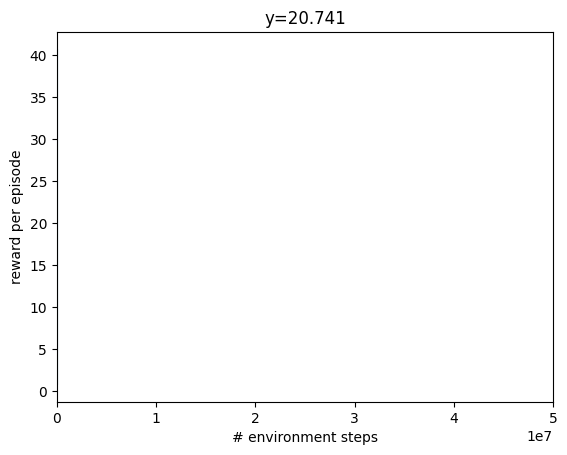

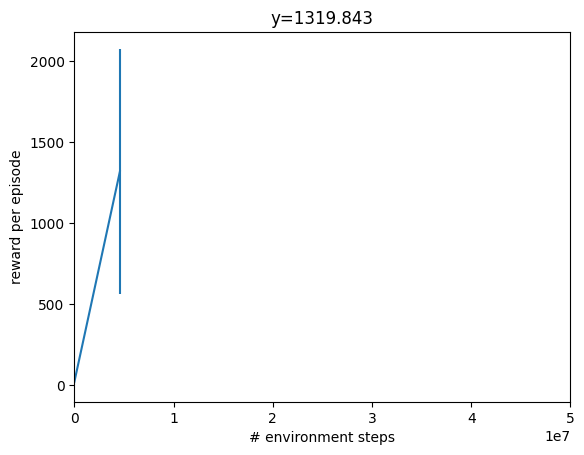

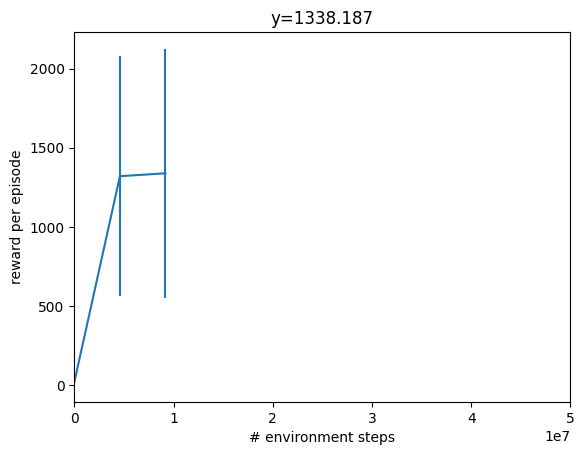

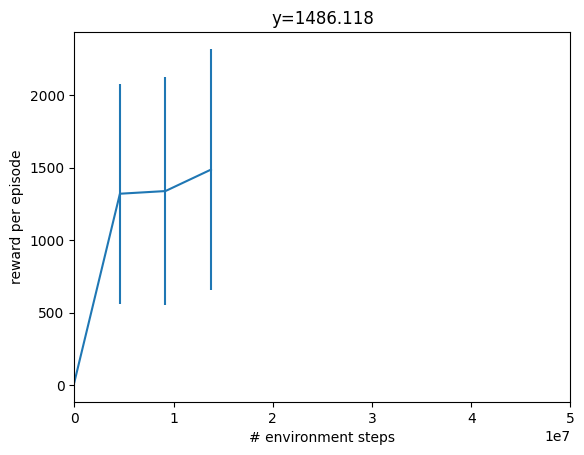

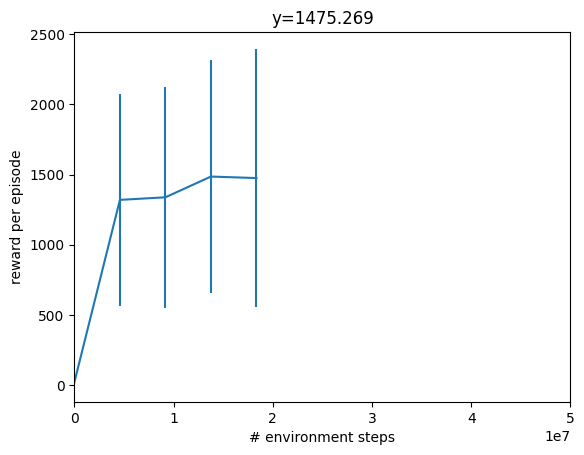

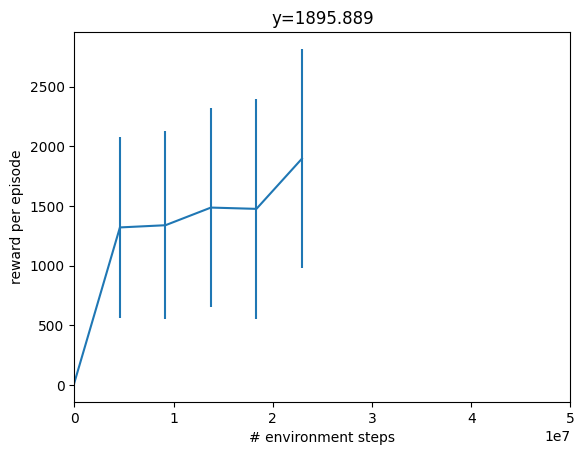

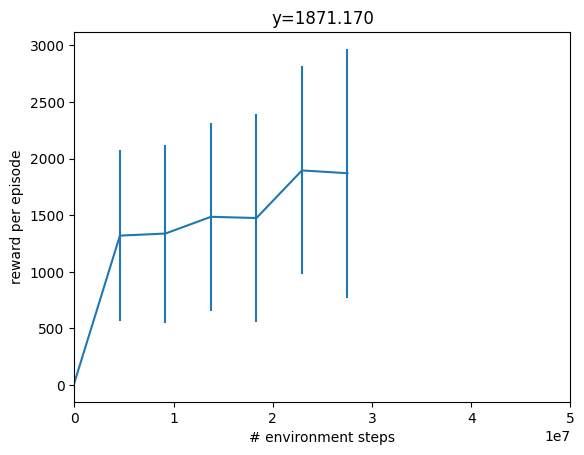

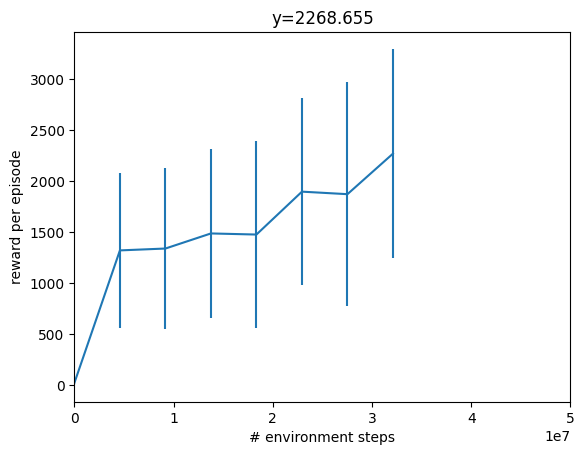

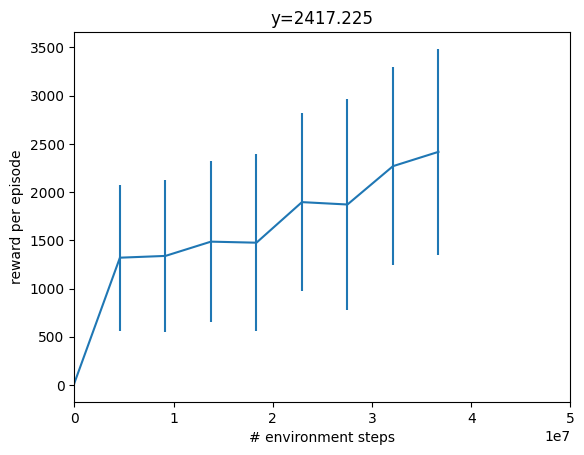

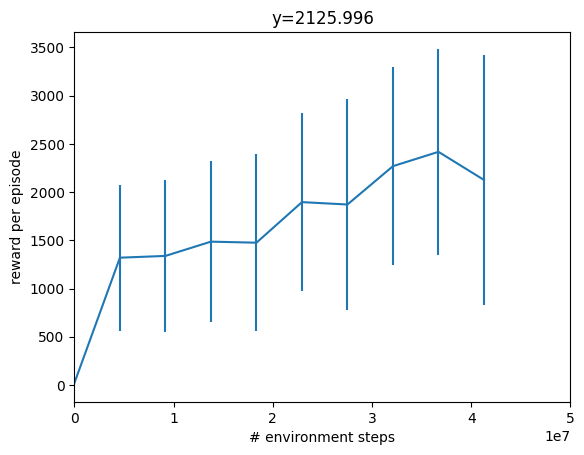

time to jit: 0:01:22.337500
time to train: 0:52:17.193575


In [25]:
make_networks_factory = functools.partial(
    ppo_networks.make_ppo_networks,
        policy_hidden_layer_sizes=(128, 128, 128))
train_fn = functools.partial(
      ppo.train, num_timesteps=40_000_000, num_evals=10,
      reward_scaling=1, episode_length=1000, normalize_observations=True,
      action_repeat=1, unroll_length=20, num_minibatches=32,
      num_updates_per_batch=4, discounting=0.97, learning_rate=3.0e-4,
      entropy_cost=1e-2, num_envs=int(8192/2), batch_size=256,
      network_factory=make_networks_factory,
      seed=0)

def progress(num_steps, metrics):
  times.append(datetime.now())
  x_data.append(num_steps)
  y_data.append(metrics['eval/episode_reward'])
  ydataerr.append(metrics['eval/episode_reward_std'])

  plt.xlim([0, train_fn.keywords['num_timesteps'] * 1.25])
#   plt.ylim([min_y, max_y])

  plt.xlabel('# environment steps')
  plt.ylabel('reward per episode')
  plt.title(f'y={y_data[-1]:.3f}')

  plt.errorbar(
      x_data, y_data, yerr=ydataerr)
  plt.show()

x_data = []
y_data = []
ydataerr = []
times = [datetime.now()]

env = HexapodV0_3(xml_path=xml_path)
eval_env = HexapodV0_3(xml_path=xml_path)
make_inference_fn, params, _= train_fn(environment=env,
                                       progress_fn=progress,
                                       eval_env=eval_env)

print(f'time to jit: {times[1] - times[0]}')
print(f'time to train: {times[-1] - times[1]}')

In [26]:
model_path = '/content/drive/MyDrive/mjx_brax_policy_7'
model.save_params(model_path, params)

In [27]:
params = model.load_params(model_path)

inference_fn = make_inference_fn(params)
jit_inference_fn = jax.jit(inference_fn)

In [30]:
eval_env = HexapodV0_3(xml_path=xml_path, physics_steps_per_control_step=1)

jit_reset = jax.jit(eval_env.reset)
jit_step = jax.jit(eval_env.step)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
rng = jax.random.PRNGKey(0)
state = jit_reset(rng)
rollout = [state.pipeline_state]

# grab a trajectory
n_steps = 1000
render_every = 1

for i in range(n_steps):
  act_rng, rng = jax.random.split(rng)
  ctrl, _ = jit_inference_fn(state.obs, act_rng)
  for i in range(env._physics_steps_per_control_step):
    state = jit_step(state, ctrl)
    rollout.append(state.pipeline_state)

  if state.done:
    break

media.show_video(env.render(rollout[::1], camera='hexapod_camera'), fps=1.0 / 0.002)

In [ ]:
media.show_video(env.render(rollout[::1], camera='hexapod_camera'), fps=1.0 / env.dt / 2)

In [ ]:
HTML(html.render(eval_env.sys.tree_replace({'opt.timestep': eval_env.dt}), rollout))

KeyError: 4